In [11]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [12]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [13]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14818,-1.3,1.0,0.5,-0.4,-0.3,-0.2,-0.3,-0.5,-0.5
16015,-1.4,1.0,0.5,-0.5,-0.3,-0.7,-0.3,0.1,1.9
7422,0.6,-0.8,0.7,-0.4,-0.1,0.7,-0.1,-0.6,-0.6
5109,0.7,-0.8,1.1,-0.5,-0.6,-0.6,-0.5,0.1,0.2
15974,-1.4,1.0,1.9,0.5,1.4,-0.1,1.2,-0.2,2.5


In [14]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [15]:
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.2,0.8,-0.1,0.6,0.3,0.1,0.3,1.5,1.2
1,0.6,-0.6,1.1,-0.5,-0.5,-0.6,-0.6,-0.1,-0.3
2,0.9,-0.9,-0.1,0.5,-0.1,0.1,0.0,1.1,0.6
3,0.6,-0.9,-0.1,-1.2,-1.2,-1.3,-1.3,1.3,1.1
4,-0.0,0.3,-0.8,-0.6,-0.7,-0.5,-0.7,-0.5,-1.1


In [16]:
#@title Double-click for possible solutions.

# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0 
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float) 


14818   0.0
16015   1.0
7422    0.0
5109    0.0
15974   1.0
         ..
13954   0.0
3761    0.0
4138    1.0
5002    0.0
5427    0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [20]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# Create a numerical feature column to represent median_income.
median_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(median_income)

# Create a numerical feature column to represent total_rooms.
tr = tf.feature_column.numeric_column("total_rooms")
feature_columns.append(tr)

# Convert the list of feature columns into a layer that will later be fed into
# the model. 
feature_layer = layers.DenseFeatures(feature_columns)

# Print the first 3 and last 3 rows of the feature_layer's output when applied
# to train_df_norm:
feature_layer(dict(train_df_norm))

<tf.Tensor 'dense_features_6/concat:0' shape=(17000, 2) dtype=float32>

In [21]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid),)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [22]:
#@title Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
17000/17000 [==============================] - 0s 27us/sample - loss: 1.1108 - accuracy: 0.2521
Epoch 2/20
17000/17000 [==============================] - 0s 13us/sample - loss: 1.0032 - accuracy: 0.2716
Epoch 3/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.9063 - accuracy: 0.3050
Epoch 4/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.8183 - accuracy: 0.3581
Epoch 5/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.7421 - accuracy: 0.4540
Epoch 6/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.6771 - accuracy: 0.5824
Epoch 7/20
17000/17000 [==============================] - 0s 20us/sample - loss: 0.6223 - accuracy: 0.6781
Epoch 8/20
17000/17000 [===============

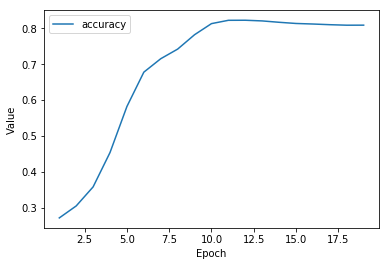

In [23]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [24]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

3000/3000 [==============================] - 0s 29us/sample - loss: 0.4069 - accuracy: 0.8007


[0.4068548580010732, 0.8006667]

Epoch 1/20
17000/17000 [==============================] - 0s 26us/sample - loss: 0.5457 - accuracy: 0.6123 - precision: 0.3823 - recall: 0.8959
Epoch 2/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.5052 - accuracy: 0.6491 - precision: 0.4054 - recall: 0.8670
Epoch 3/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4726 - accuracy: 0.6832 - precision: 0.4306 - recall: 0.8319
Epoch 4/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4469 - accuracy: 0.7175 - precision: 0.4618 - recall: 0.7902
Epoch 5/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4278 - accuracy: 0.7441 - precision: 0.4920 - recall: 0.7514
Epoch 6/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4152 - accuracy: 0.7674 - precision: 0.5255 - recall: 0.7120
Epoch 7/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4066 - accuracy: 0.7824 - precision: 0.5524 - recall:

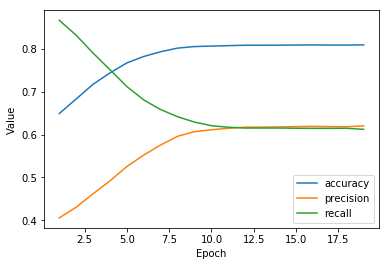

In [25]:
#@title Double-click to view the solution for Task 3.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

Epoch 1/20
17000/17000 [==============================] - 0s 28us/sample - loss: 0.5547 - accuracy: 0.7496 - precision: 0.4992 - recall: 0.6988
Epoch 2/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.5053 - accuracy: 0.7822 - precision: 0.5536 - recall: 0.6631
Epoch 3/20
17000/17000 [==============================] - 0s 15us/sample - loss: 0.4703 - accuracy: 0.8008 - precision: 0.5946 - recall: 0.6369
Epoch 4/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4458 - accuracy: 0.8122 - precision: 0.6285 - recall: 0.6070
Epoch 5/20
17000/17000 [==============================] - 0s 18us/sample - loss: 0.4278 - accuracy: 0.8199 - precision: 0.6595 - recall: 0.5773
Epoch 6/20
17000/17000 [==============================] - 0s 18us/sample - loss: 0.4151 - accuracy: 0.8264 - precision: 0.6939 - recall: 0.5456
Epoch 7/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4065 - accuracy: 0.8317 - precision: 0.7289 - recall:

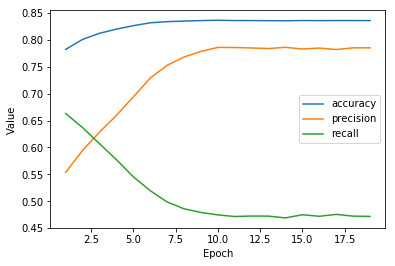

In [26]:
#@title Double-click to view the solution for Task 4.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Epoch 1/20
17000/17000 [==============================] - 1s 32us/sample - loss: 0.6217 - auc: 0.7998
Epoch 2/20
17000/17000 [==============================] - 0s 17us/sample - loss: 0.5608 - auc: 0.8231
Epoch 3/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.5124 - auc: 0.8297
Epoch 4/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4754 - auc: 0.8332
Epoch 5/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4474 - auc: 0.8345
Epoch 6/20
17000/17000 [==============================] - 0s 13us/sample - loss: 0.4276 - auc: 0.8356
Epoch 7/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4146 - auc: 0.8356
Epoch 8/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4063 - auc: 0.8364
Epoch 9/20
17000/17000 [==============================] - 0s 14us/sample - loss: 0.4017 - auc: 0.8365
Epoch 10/20
17000/17000 [==============================] - 0s 15us/sample - loss: 

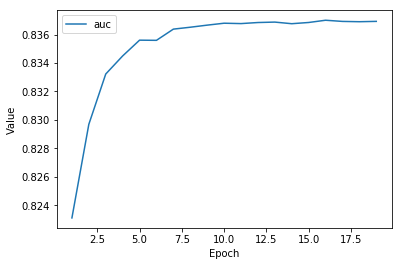

In [27]:
#@title Double-click to view the solution for Task 5.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)